In [1]:
# Импорт библиотек
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from sklearn.ensemble import IsolationForest, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.svm import OneClassSVM, SVC
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split

In [2]:
# Первый датасет, импорт данных
weight_height = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_04_visualization/data/weight-height.csv')
weight_height.head(10)

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801
5,Male,67.253016,152.212156
6,Male,68.785081,183.927889
7,Male,68.348516,167.971110
8,Male,67.018950,175.929440
9,Male,63.456494,156.399676


In [3]:
# Информация о датафрейме. 3 колонки, 10_000 строк. Пропущенных значений нет. Типы данных роста и веса числовые.
weight_height.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gender  10000 non-null  object 
 1   Height  10000 non-null  float64
 2   Weight  10000 non-null  float64
dtypes: float64(2), object(1)
memory usage: 234.5+ KB


In [4]:
weight_height.duplicated().sum()

0

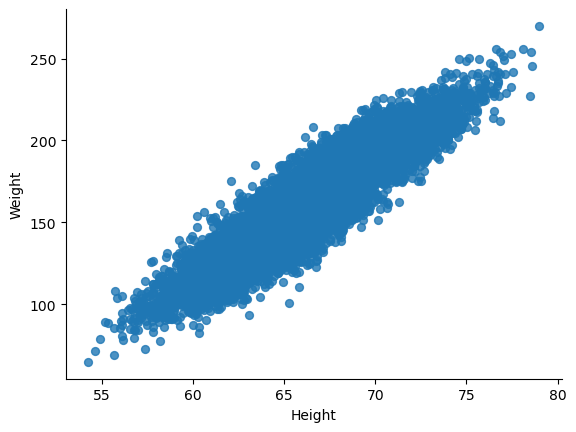

In [5]:
# Визуализация первого датасета
weight_height.plot(kind='scatter', x='Height', y='Weight', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

### Задание 1. Сравнение моделей обучения с учителем (4 балла)
Используя разные алгоритмы машинного обучения, проанализируйте наш датасет на наличие выбросов и аномалий. В качестве переменных для анализа используйте только вес и рост.

Создайте поле из 6 графиков. Каждый график (`scatter plot`) должен иметь заголовок, названия полей, прозрачность точек 0.8. Должны отсутствовать рамки со всех сторон. Пометьте аномалии красным цветом, а все остальные данные — зеленым.

Поместите на графики следующие 6 алгоритмов:

- Interquartile range (IQR) — возьмите выбросы по `x` и `y`.
- Isolation forest.
- Local Outlier Factor.
- One-class SVM.
- Gaussian Mixture.
- DBSCAN.  

Напишите, какие модели показали себя лучше всего и почему.

In [6]:
# Независимые переменные
X = weight_height[['Height', 'Weight']]

In [7]:
# 1. Interquartile Range (IQR)
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((X < (Q1 - 1.5*IQR)) | (X > (Q3 + 1.5*IQR))).any(axis=1)
outliers_iqr

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Length: 10000, dtype: bool

In [8]:
# 2. Isolation Forest
isof = IsolationForest(contamination=0.01)
y_pred_isof = isof.fit_predict(X)
outliers_isof = y_pred_isof == -1
outliers_isof

array([ True, False, False, ..., False, False, False])

In [9]:
# 3. Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
y_pred_lof = lof.fit_predict(X)
outliers_lof = y_pred_lof == -1
outliers_lof

array([False, False, False, ..., False, False, False])

In [10]:
# 4. One-class SVM
svm = OneClassSVM(nu=0.01)
y_pred_svm = svm.fit_predict(X)
outliers_svm = y_pred_svm == -1
outliers_svm

array([ True, False, False, ..., False, False, False])

In [11]:
# 5. Gaussian Mixture
gmm = GaussianMixture(n_components=3, covariance_type='full').fit(X)
scores_gmm = gmm.score_samples(X)
threshold = np.percentile(scores_gmm, 5)
outliers_gmm = scores_gmm < threshold
outliers_gmm

array([ True, False, False, ..., False, False, False])

In [12]:
# 6. DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
y_pred_dbscan = dbscan.fit_predict(X)
outliers_dbscan = y_pred_dbscan == -1
outliers_dbscan

array([ True,  True, False, ..., False, False, False])

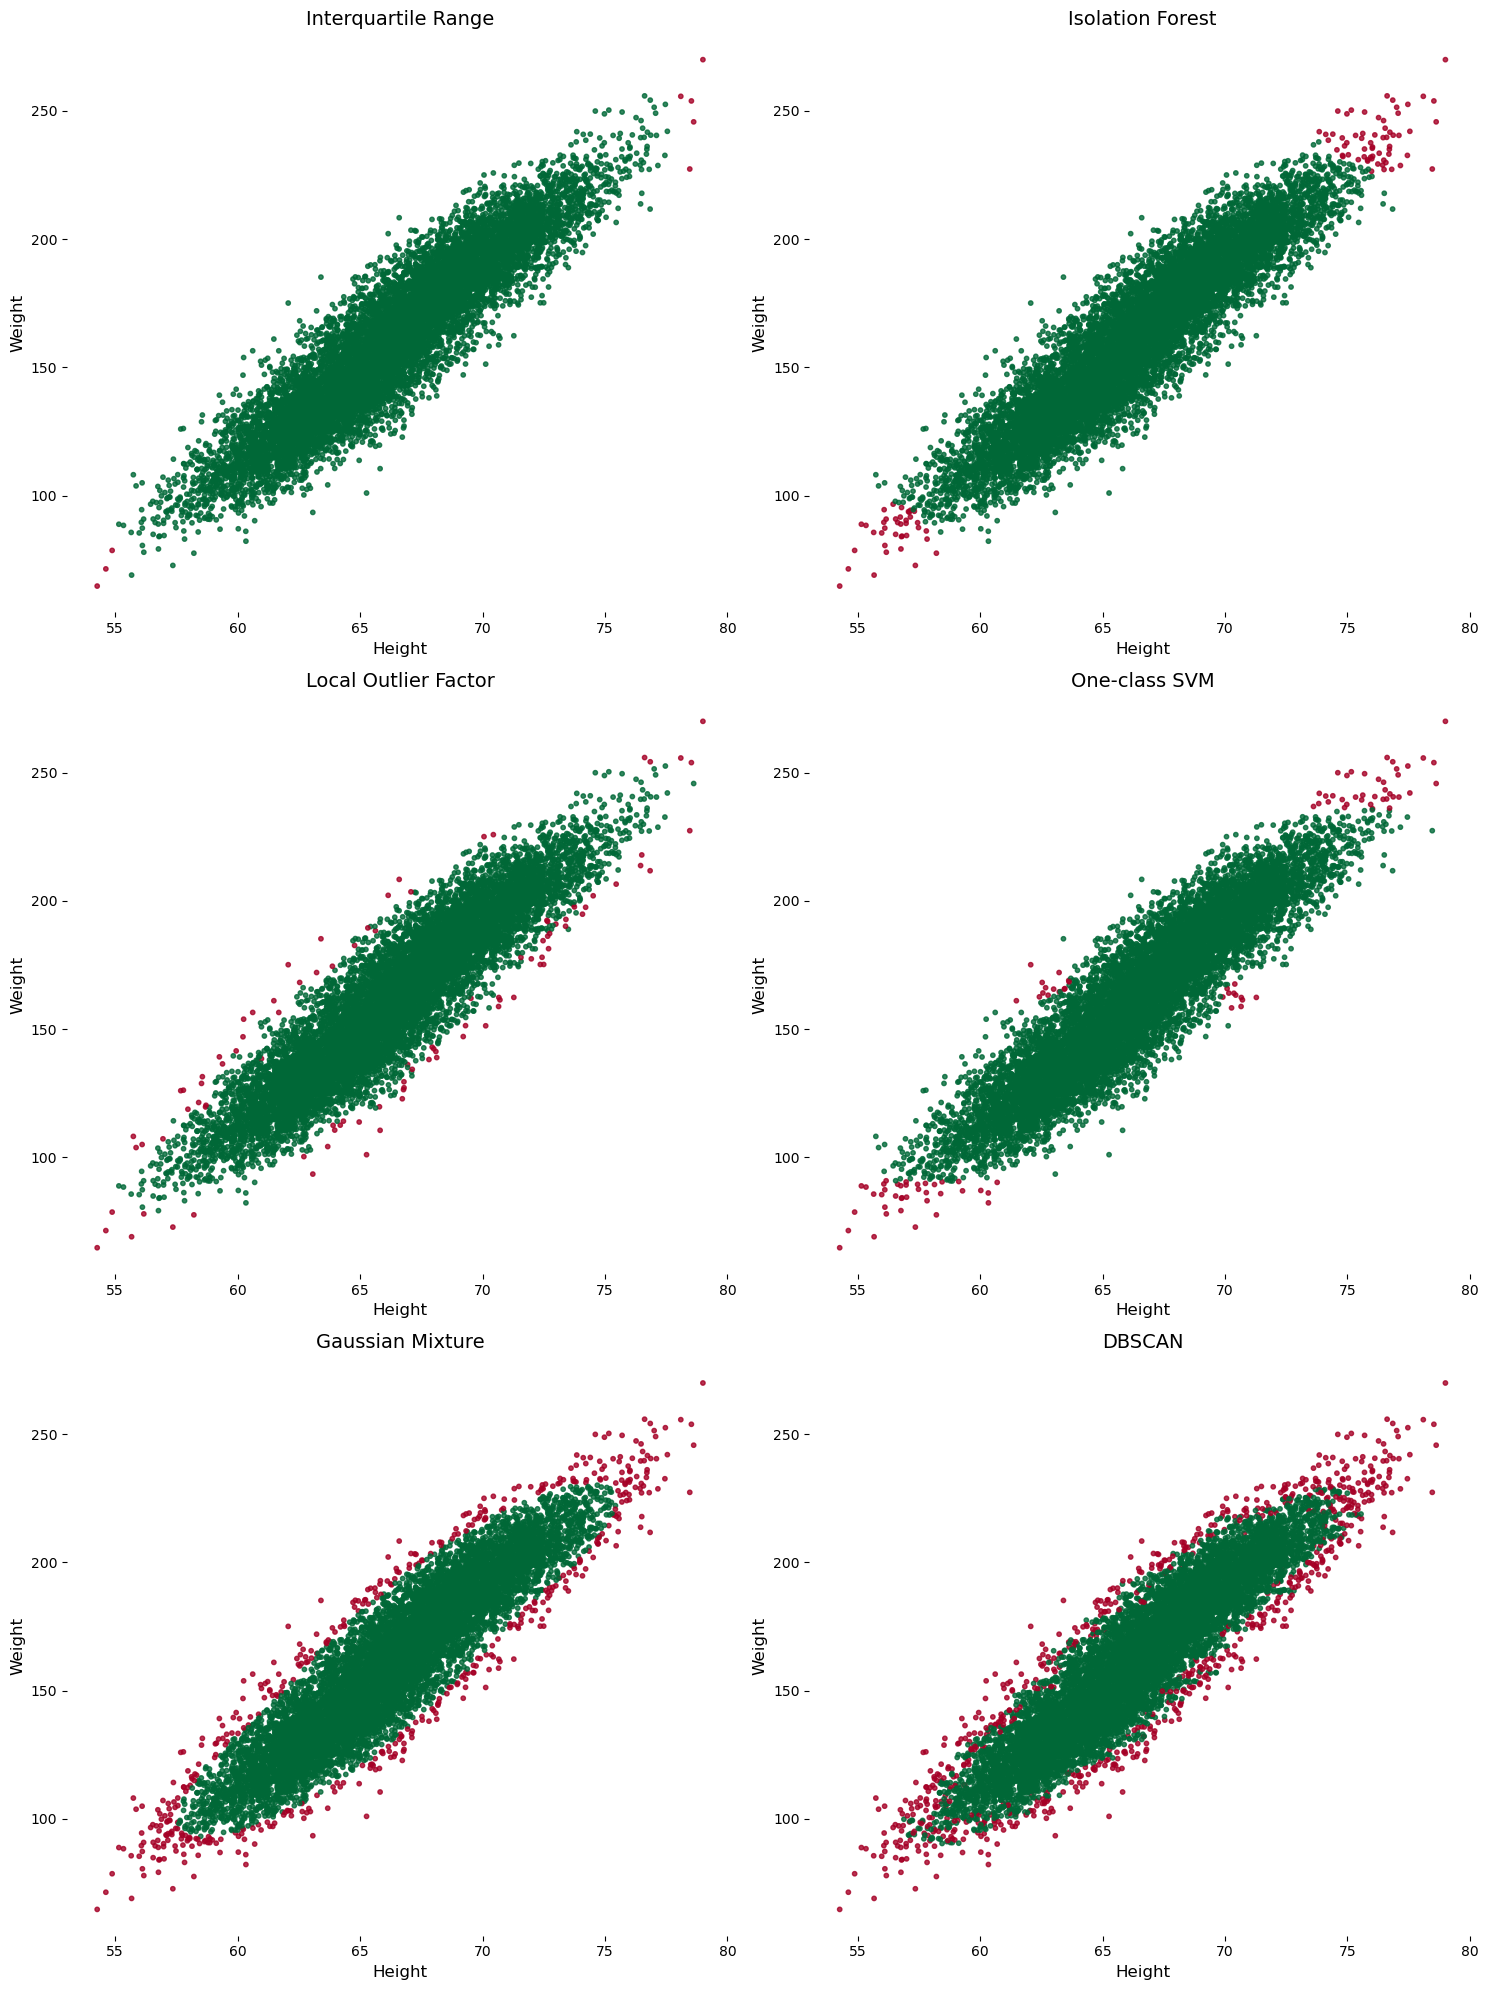

In [13]:
# Визулизация работы алгоритмов машинного обучения на поиск выбросов и аномалий
# Настройка фигуры для графиков
fig, axs = plt.subplots(3, 2, figsize=(15, 20))

# Отсутствие рамок со всех сторон
for ax in axs.flat:
    ax.set_frame_on(False)

# Список алгоритмов и выбросов/аномалий
algo_anomaly = [('Interquartile Range', outliers_iqr), ('Isolation Forest', outliers_isof),
                ('Local Outlier Factor', outliers_lof), ('One-class SVM', outliers_svm),
                ('Gaussian Mixture', outliers_gmm), ('DBSCAN', outliers_dbscan)]

# Графики на subplots
for ax, (title, mask) in zip(axs.flat, algo_anomaly):
    ax.scatter(X['Height'], X['Weight'], c=~mask, alpha=0.8, cmap='RdYlGn', s=10)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Height', fontsize=12)
    ax.set_ylabel('Weight', fontsize=12)

plt.tight_layout()
plt.show()

IQR обнаруживает выбросы на основе межквартильного размаха. Этот метод хорошо работает для данных с приблизительно симметричным распределением. Выбросы распознаны на краях распределения по весу и росту (3 снизу и 5 сверху).  
Isolation Forest обнаруживает аномалии на основе изоляции точек. Идентифицированы аномалии не только по краям сверху и снизу, но и заходя немного вглубь.  
Local Outlier Factor определяет аномалии на основе плотности их локального окружения. Выявлены аномалии преимущественно среди точек, расположенных далеко от основной массы данных (овал из небольшого кол-ва точек вокруг точек данных).  
One-class SVM находит границу, которая отделяет большую часть данных от потенциальных выбросов. Выявлены аномалии так скажем, с 4-х сторон (по краям слева, справа и небольшое кол-во точек, скошенных вправо, влево)  
Gaussian Mixture определяет аномалии в данных, которые могут быть хорошо апроксимированы смесью гауссовских распределений. Здесь важен выбор кол-ва компонентов. Идентифицированы аномалии вокруг распределения, выписав овал, выделил выбросы среди менее вероятных точек.  
DBSCAN кластеризует данные, основываясь на плотности, идентифицирует аномалии как точки, не принадлежащие основным кластерам. Выбор параметров eps и min_samples может существенно повлиять на результаты. Выделены аномалии схожим образом с GMM, захватив большее кол-во точек по внешнему овалу и немного заходя вглубь.  

Исходя из распределения роста и веса (примерно видно, чем выше человек, тем больше его вес), хорошо себя показали Local Outlier Factor, Gaussian Mixture. Они идентифицировали аномалии, не нарушая основную закономерность распределения точек. Аномалии, выделенные этими методами, в основном находились вдали от центральной области распределения, что указывает на их способность выделять отклоняющиеся наблюдения, помимо этого модели выделяли выбросы по всему диапазону роста и веса, а не только на краях распределения.

In [14]:
# Второй датасет, импорт данных
thyroid = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_04_visualization/data/annthyroid_unsupervised_anomaly_detection.csv', sep=';').iloc[:, :-2]
thyroid.head()

,Age,Sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,goitre,tumor,hypopituitary,psych,TSH,T3_measured,TT4_measured,T4U_measured,FTI_measured,Outlier_label
0,0.45,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,61.0,6.0,23.0,87.0,26.0,o
1,0.61,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,29.0,15.0,61.0,96.0,64.0,o
2,0.16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,29.0,19.0,58.0,103.0,56.0,o
3,0.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,114.0,3.0,24.0,61.0,39.0,o
4,0.75,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,49.0,3.0,5.0,116.0,4.0,o


In [15]:
# Информация о датафрейме. 6916 строк, 22 колонки. Пропущенных значений нет. 
thyroid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6916 entries, 0 to 6915
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        6916 non-null   float64
 1   Sex                        6916 non-null   float64
 2   on_thyroxine               6916 non-null   float64
 3   query_on_thyroxine         6916 non-null   float64
 4   on_antithyroid_medication  6916 non-null   float64
 5   sick                       6916 non-null   float64
 6   pregnant                   6916 non-null   float64
 7   thyroid_surgery            6916 non-null   float64
 8   I131_treatment             6916 non-null   float64
 9   query_hypothyroid          6916 non-null   float64
 10  query_hyperthyroid         6916 non-null   float64
 11  lithium                    6916 non-null   float64
 12  goitre                     6916 non-null   float64
 13  tumor                      6916 non-null   float

In [16]:
# Уникальные значения колонок. Содержит 16 категориальных атрибутов, 5 числовых атрибутов и 1 целевой атрибут.
for col in thyroid.columns:
    print(thyroid[col].value_counts())

0.72      155
0.60      153
0.61      152
0.59      149
0.70      147
         ... 
0.05        2
0.03        2
0.09        1
0.06        1
515.00      1
Name: Age, Length: 98, dtype: int64
0.0    4789
1.0    2127
Name: Sex, dtype: int64
0.0    5985
1.0     931
Name: on_thyroxine, dtype: int64
0.0    6808
1.0     108
Name: query_on_thyroxine, dtype: int64
0.0    6825
1.0      91
Name: on_antithyroid_medication, dtype: int64
0.0    6651
1.0     265
Name: sick, dtype: int64
0.0    6838
1.0      78
Name: pregnant, dtype: int64
0.0    6817
1.0      99
Name: thyroid_surgery, dtype: int64
0.0    6800
1.0     116
Name: I131_treatment, dtype: int64
0.0    6482
1.0     434
Name: query_hypothyroid, dtype: int64
0.0    6436
1.0     480
Name: query_hyperthyroid, dtype: int64
0.0    6826
1.0      90
Name: lithium, dtype: int64
0.0    6857
1.0      59
Name: goitre, dtype: int64
0.0    6740
1.0     176
Name: tumor, dtype: int64
0.0    6915
1.0       1
Name: hypopituitary, dtype: int64
0.0    6572
1.0

### Задание 2. Проверка влияния параметров Isolation Forest на итоговые параметры (3 балла)
После обучения модели выполните следующее:

- Обучите модель Isolation Forest на данных Х с использованием найденных оптимальных параметров (для этого оберните Isolation Forest в [sklearn.model_selection.GridSearchCV)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). В `GridSearchCV` используйте params = `{'n_estimators': list(range(5, 15)), 'max_features': list(range(2, 10))}`.
- Сделайте предсказания на данных Х.
- Поиграйте с параметром `n_jobs` — создайте 6 разных визуализаций с параметрами от 1 до 6.
- Замените значения предсказаний, где 1 соответствует «нормальному» наблюдению (normal), а -1 — «выбросу» (outlier).
- Выведите лучшие параметры модели Isolation Forest для всех 6 параметров (для лучшего понимания оформите выводы).

### Задание 3. Визуализация ROC-кривой в зависимости от параметров Isolation Forest (3 балла)
Для каждого Isolation Forest создайте отдельную `roc_curve` и полотно с шестью графиками для визуализации шести ROC-кривых в зависимости от параметра n_jobs.

В название каждого графика выведите F1-score, Precision и Recall для каждой модели Isolation Forest.

In [17]:
# Подготовка данных для модели
X_thyroid = thyroid.iloc[:, :-1]
y_true_thyroid = thyroid.iloc[:, -1].map({'o': -1, 'n': 1})
#X_train, X_test, y_train, y_test = train_test_split(X_thyroid, y_true_thyroid, test_size=0.2, random_state=42)

In [18]:
# Параметры для GridSearchCV
params = {
    'n_estimators': list(range(5, 15)),
    'max_features': list(range(2, 10))
}

In [19]:
# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, ax, title):
    cm = confusion_matrix(y_true, y_pred, labels=[1, -1])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                xticklabels=['Normal', 'Outlier'], yticklabels=['Normal', 'Outlier'])
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(title)

Лучшие параметры для n_jobs=1: {'max_features': 6, 'n_estimators': 13}
Время выполнения для n_jobs=1: 16.741 секунд
--------------------
Classification Report for n_jobs = 1:
              precision    recall  f1-score   support

          -1       0.18      0.31      0.23       250
           1       0.97      0.95      0.96      6666

    accuracy                           0.93      6916
   macro avg       0.58      0.63      0.60      6916
weighted avg       0.94      0.93      0.93      6916



Лучшие параметры для n_jobs=2: {'max_features': 6, 'n_estimators': 13}
Время выполнения для n_jobs=2: 14.878 секунд
--------------------
Classification Report for n_jobs = 2:
              precision    recall  f1-score   support

          -1       0.18      0.31      0.23       250
           1       0.97      0.95      0.96      6666

    accuracy                           0.93      6916
   macro avg       0.58      0.63      0.60      6916
weighted avg       0.94      0.93      0.93      

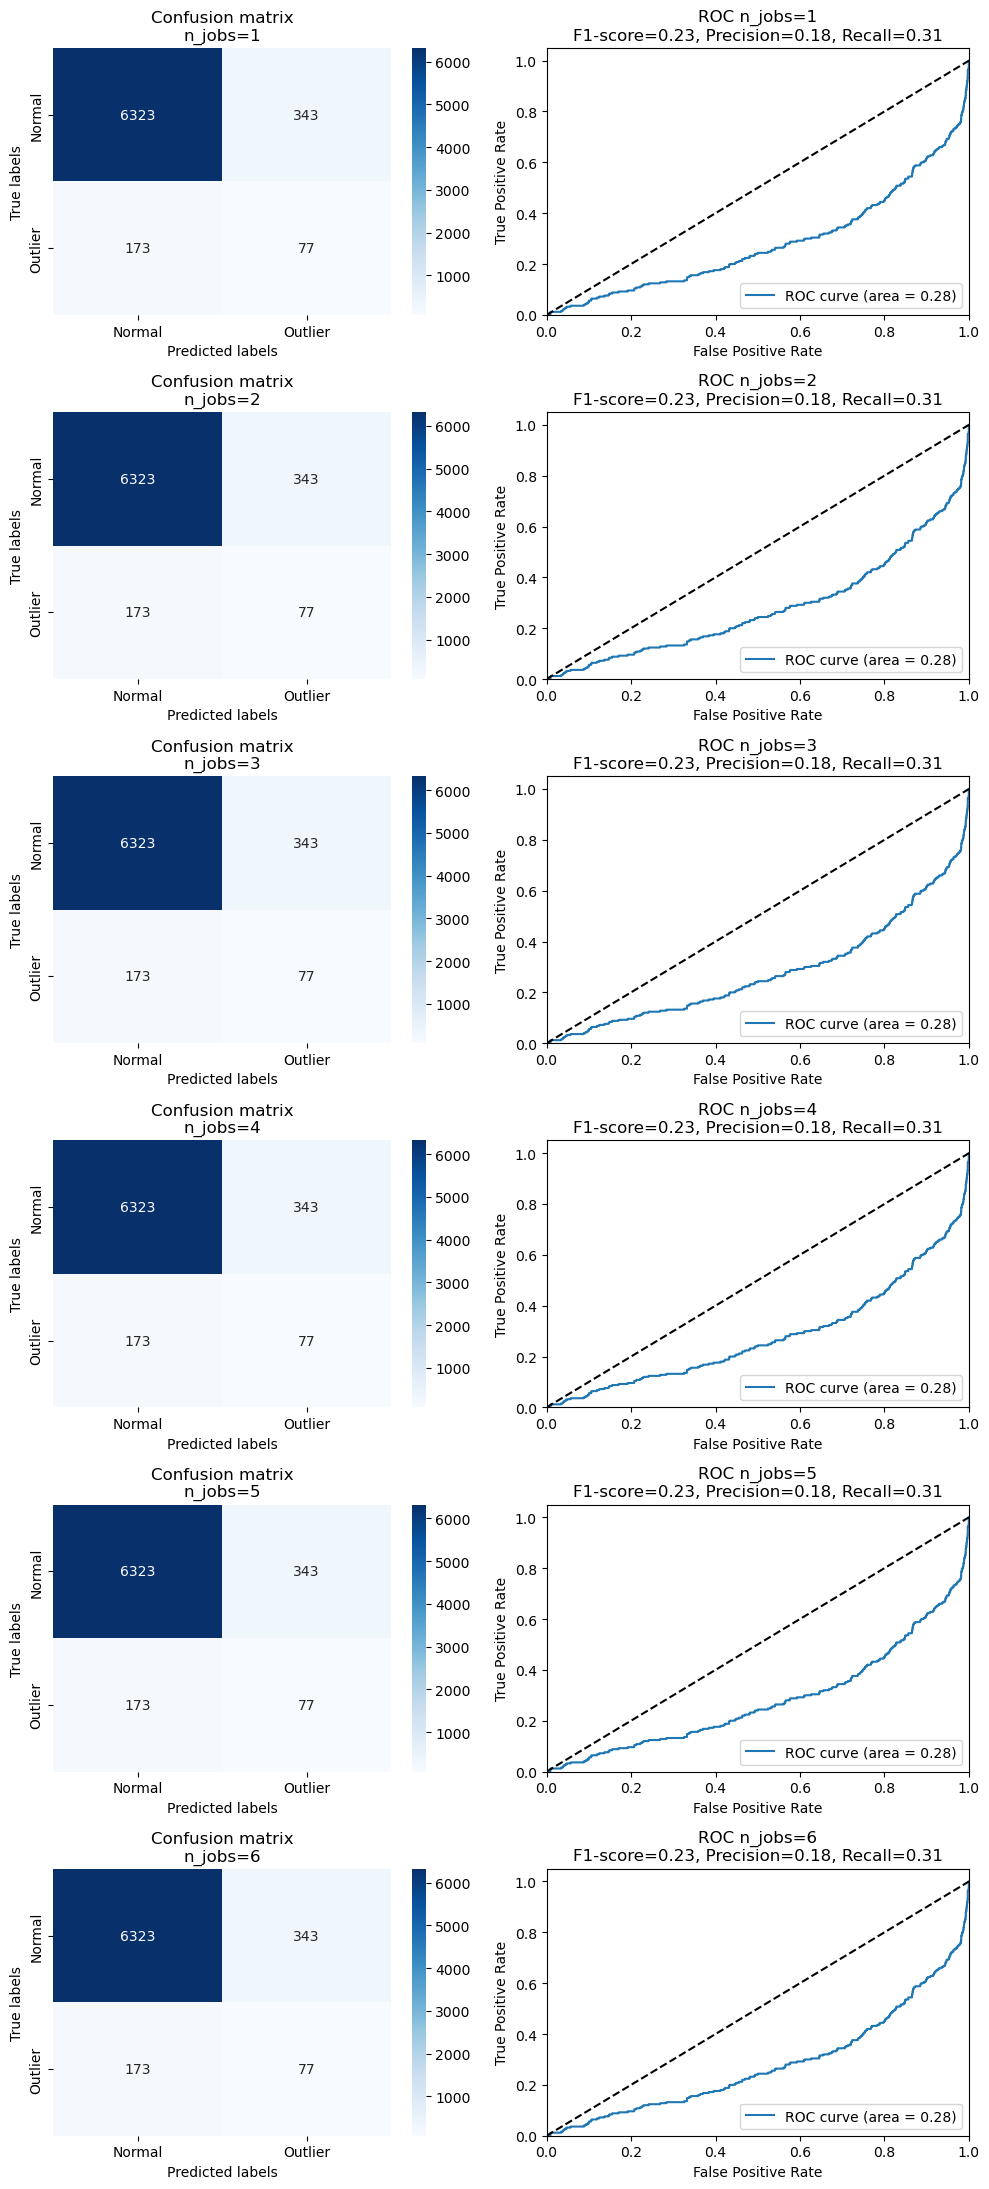

In [20]:
# Subplots для визуализации ROC-кривых и Confusion Matrix
fig, axs = plt.subplots(6, 2, figsize=(10, 22))

for index, n_jobs in enumerate(range(1, 7)):
    # Начало замера времени
    start_time = time.time()
    
    # GridSearchCV и обучение модели
    grid_search = GridSearchCV(IsolationForest(random_state=42), params, scoring='f1', cv=5, n_jobs=n_jobs)
    grid_search.fit(X_thyroid, y_true_thyroid)
    
    # Конец замера времени, вычисление затраченного времени
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Получение лучшей модели
    best_model = grid_search.best_estimator_
    
    # Получение предсказаний
    y_pred = best_model.predict(X_thyroid)
    
    # Вычисление метрик
    f1 = f1_score(y_true_thyroid, y_pred, pos_label=-1)
    precision = precision_score(y_true_thyroid, y_pred, pos_label=-1)
    recall = recall_score(y_true_thyroid, y_pred, pos_label=-1)

    # Вывод лучших параметров и затраченного времени на выполнение поиска, classification report
    print(f'Лучшие параметры для n_jobs={n_jobs}: {grid_search.best_params_}')
    print(f'Время выполнения для n_jobs={n_jobs}: {elapsed_time:.3f} секунд')
    print('-'*20)
    
    print(f"Classification Report for n_jobs = {n_jobs}:")
    print(classification_report(y_true_thyroid, y_pred))
    print("\n" + "="*60 + "\n")

    # Confusion Matrix
    plot_confusion_matrix(y_true_thyroid, y_pred, axs[index, 0], f'Confusion matrix\nn_jobs={n_jobs}')

    # Построение ROC-кривой и вычисление AUC
    scores_pred = best_model.decision_function(X_thyroid)
    fpr, tpr, _ = roc_curve(y_true_thyroid, scores_pred, pos_label=-1)
    roc_auc = auc(fpr, tpr)
    
    # Преобразование меток
    y_pred_transformed = np.where(y_pred == 1, 'normal', 'outlier')

    # Визуализация ROC-кривой
    axs[index, 1].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    axs[index, 1].plot([0, 1], [0, 1], 'k--')
    axs[index, 1].set_xlim([0.0, 1.0])
    axs[index, 1].set_ylim([0.0, 1.05])
    axs[index, 1].set_xlabel('False Positive Rate')
    axs[index, 1].set_ylabel('True Positive Rate')
    axs[index, 1].set_title(f'ROC n_jobs={n_jobs}\nF1-score={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}')
    axs[index, 1].legend(loc='lower right')

plt.tight_layout()
plt.show()

Для ROC-кривой и метрик F1-score, Precision, Recall поставлен pos_label=-1 (outlier). Как видно из визуализаций и classification_report из 250 наблюдений, которые помечены как outlier, только 77 разпознано, как outlier, метрика низкая по качеству (F1-score=0.23). Нормальные данные распознаны хорошо (F1-score=0.96). Данные не были сбалансированы.  
Для pos_label=1 визуализации представлены ниже.

Как видно из разных визуализаций, n_jobs влияет только на скорость вычислений, позволяя использовать несколько ядер процессора для параллельных вычислений, но не влияет на результаты обучения модели или на выбор параметров модели. Для сравнения для каждой итерации цикла замерили время исполнения GridSearchCV. Для `n_jobs` 4-6 время исполнения поиска минимальная, сравнивая с остальными числами от 1 до 6. Оптимальными параметрами для Isolation Forest оказались `max_features`: 6, `n_estimators`: 13.

Лучшие параметры для n_jobs=1: {'max_features': 6, 'n_estimators': 13}
Время выполнения для n_jobs=1: 16.875 секунд
--------------------
Classification Report for n_jobs = 1:
              precision    recall  f1-score   support

          -1       0.18      0.31      0.23       250
           1       0.97      0.95      0.96      6666

    accuracy                           0.93      6916
   macro avg       0.58      0.63      0.60      6916
weighted avg       0.94      0.93      0.93      6916



Лучшие параметры для n_jobs=2: {'max_features': 6, 'n_estimators': 13}
Время выполнения для n_jobs=2: 15.680 секунд
--------------------
Classification Report for n_jobs = 2:
              precision    recall  f1-score   support

          -1       0.18      0.31      0.23       250
           1       0.97      0.95      0.96      6666

    accuracy                           0.93      6916
   macro avg       0.58      0.63      0.60      6916
weighted avg       0.94      0.93      0.93      

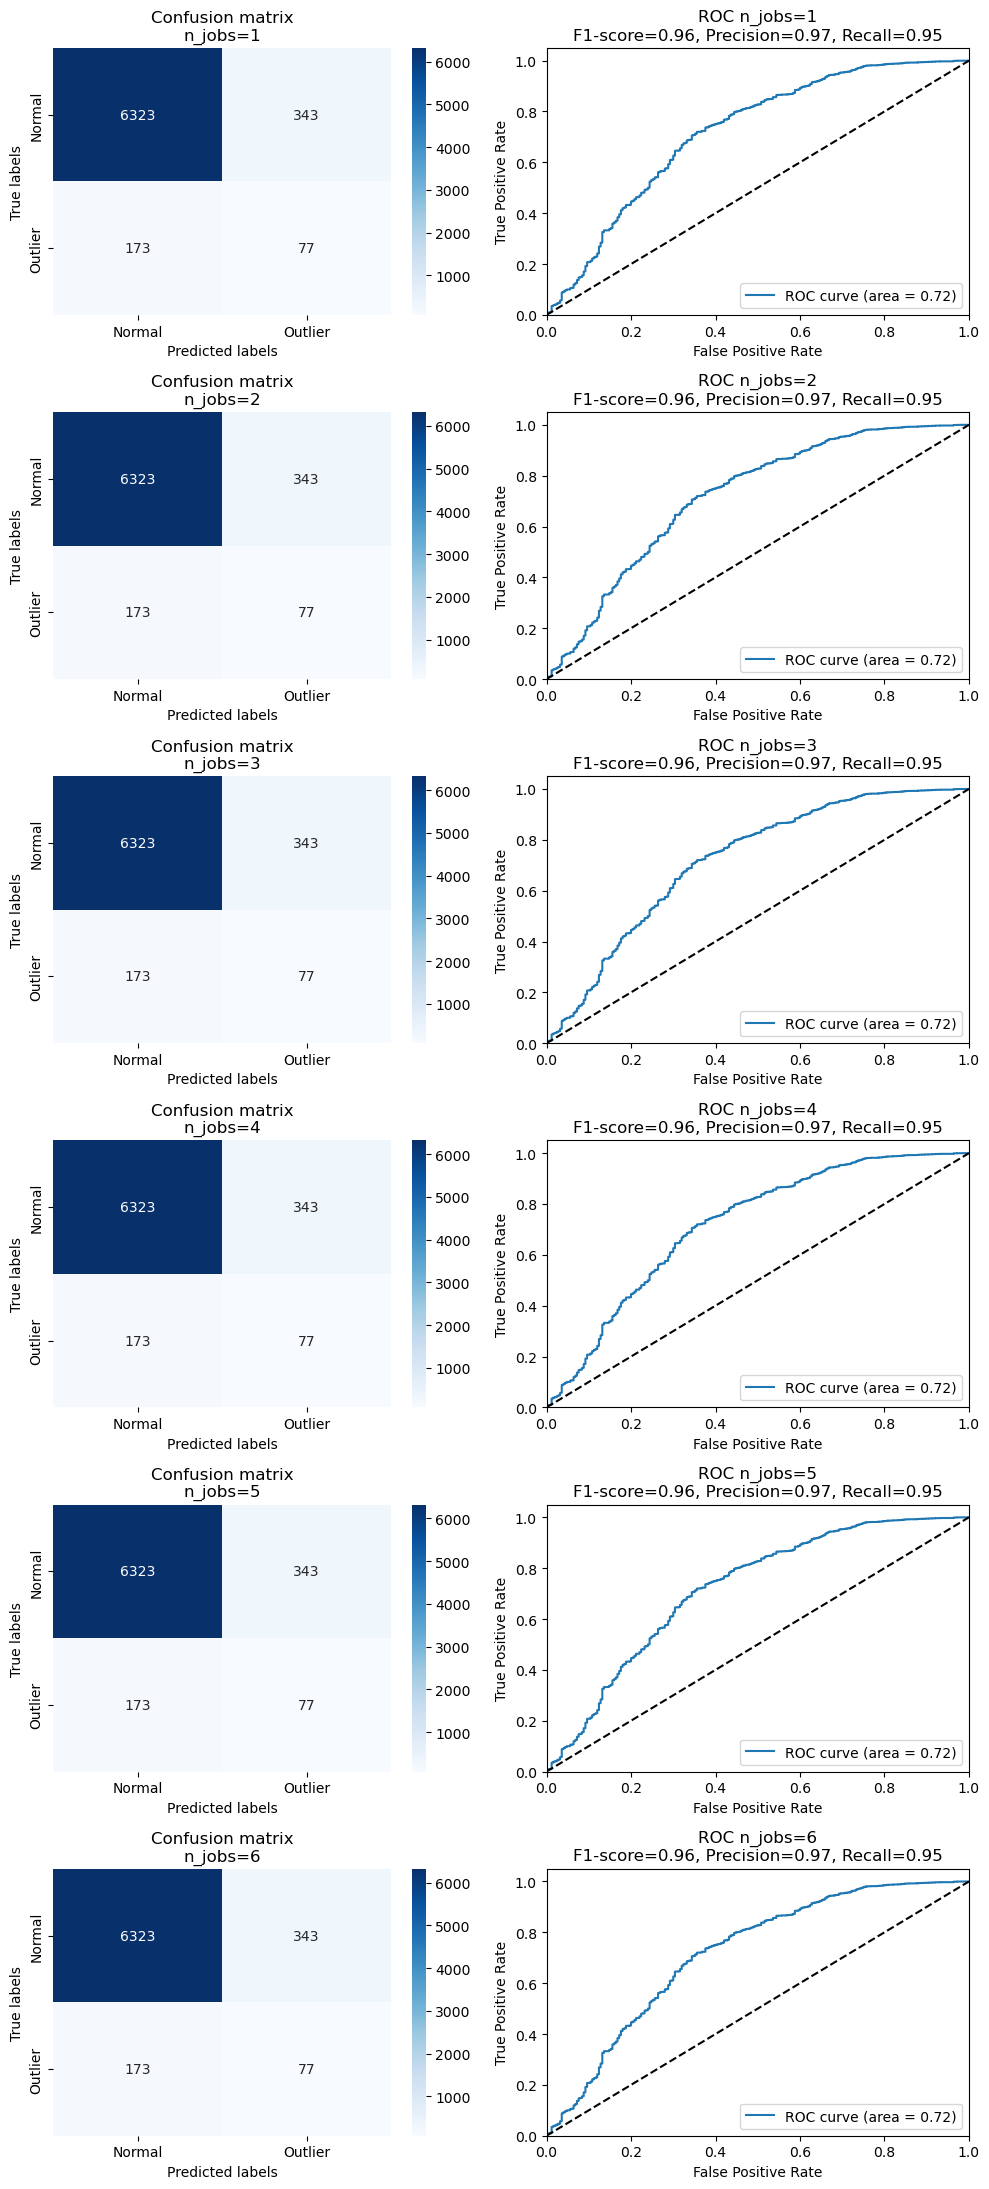

In [21]:
# Subplots для визуализации ROC-кривых и Confusion Matrix
fig, axs = plt.subplots(6, 2, figsize=(10, 22))

for index, n_jobs in enumerate(range(1, 7)):
    # Начало замера времени
    start_time = time.time()
    
    # GridSearchCV и обучение модели
    grid_search = GridSearchCV(IsolationForest(random_state=42), params, scoring='f1', cv=5, n_jobs=n_jobs)
    grid_search.fit(X_thyroid, y_true_thyroid)
    
    # Конец замера времени, вычисление затраченного времени
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Получение лучшей модели
    best_model = grid_search.best_estimator_
    
    # Получение предсказаний
    y_pred = best_model.predict(X_thyroid)
    
    # Вычисление метрик
    f1 = f1_score(y_true_thyroid, y_pred)
    precision = precision_score(y_true_thyroid, y_pred)
    recall = recall_score(y_true_thyroid, y_pred)

    # Вывод лучших параметров и затраченного времени на выполнение поиска, classification report
    print(f'Лучшие параметры для n_jobs={n_jobs}: {grid_search.best_params_}')
    print(f'Время выполнения для n_jobs={n_jobs}: {elapsed_time:.3f} секунд')
    print('-'*20)
    
    print(f"Classification Report for n_jobs = {n_jobs}:")
    print(classification_report(y_true_thyroid, y_pred))
    print("\n" + "="*60 + "\n")

    # Confusion Matrix
    plot_confusion_matrix(y_true_thyroid, y_pred, axs[index, 0], f'Confusion matrix\nn_jobs={n_jobs}')

    # Построение ROC-кривой и вычисление AUC
    scores_pred = best_model.decision_function(X_thyroid)
    fpr, tpr, _ = roc_curve(y_true_thyroid, scores_pred)
    roc_auc = auc(fpr, tpr)
    
    # Преобразование меток
    y_pred_transformed = np.where(y_pred == 1, 'normal', 'outlier')

    # Визуализация ROC-кривой
    axs[index, 1].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    axs[index, 1].plot([0, 1], [0, 1], 'k--')
    axs[index, 1].set_xlim([0.0, 1.0])
    axs[index, 1].set_ylim([0.0, 1.05])
    axs[index, 1].set_xlabel('False Positive Rate')
    axs[index, 1].set_ylabel('True Positive Rate')
    axs[index, 1].set_title(f'ROC n_jobs={n_jobs}\nF1-score={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}')
    axs[index, 1].legend(loc='lower right')

plt.tight_layout()
plt.show()

In [22]:
# Третий датасет, импорт данных
placement = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_04_visualization/data/placement.csv')
placement.head()

,cgpa,placement_exam_marks,placed
0,7.19,26.0,1
1,7.46,38.0,1
2,7.54,40.0,1
3,6.42,8.0,1
4,7.23,17.0,0


In [23]:
# Информация о датафрейме. 1_000 строк, 3 колонки. Пропущенных значений нет.
placement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cgpa                  1000 non-null   float64
 1   placement_exam_marks  1000 non-null   float64
 2   placed                1000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 23.6 KB


In [24]:
# Сбалансированность классов целевого признака
placement['placed'].value_counts()

0    511
1    489
Name: placed, dtype: int64

### Задание 4. Проверка эффективности моделей без учителя (4 балла)
Ранее мы обсуждали, что методы обучения с учителем можно использовать не только для поиска аномалий, но и для классической классификации. Аналогично первому заданию, используя разные алгоритмы обучения с учителем, постройте модель для классификации по данным датасета.

Наш третий датасет — данные по принятым и не принятым в университет студентам в зависимости от их среднего балла и балла за экзамен. В качестве переменных для анализа используйте средний балл (`cgpa`) и балл за экзамен (`placement_exam_marks`), а в качестве зависимой переменной в кластеризации используйте переменную `placed`.

Создайте поле из шести графиков. Каждый график должен представлять собой `confusion_matrix` (heatmap или тепловую карту) с попаданиями модели (матрица 2 на 2 с попаданиями модели, как делали на третьей неделе). Каждый график должен иметь заголовок и названия полей. На тепловой карте на каждом квадратике должно быть указано число, а также colorbar с правой стороны.

Поместите на графики следующие 6 алгоритмов:

- k-Nearest Neighbors (KNN).
- SVM (Support Vector Machine).
- Random Forest.
- AdaBoost.
- Gradient Boosting.
- Decision Tree.

In [25]:
# Импорт библиотеки
from sklearn.preprocessing import StandardScaler

In [26]:
# Подготовка данных для обучения
X_place = placement[['cgpa', 'placement_exam_marks']]
y_place = placement['placed']

# Разделение данных
X_train_place, X_test_place, y_train_place, y_test_place = train_test_split(X_place, y_place, test_size=0.3, random_state=42)

In [27]:
# Стандартизация данных
#scaler = StandardScaler()
#X_train_place = scaler.fit_transform(X_train_place)
#X_test_place = scaler.transform(X_test_place)

In [28]:
# Список алгоритмов
models = [
    ('KNN', KNeighborsClassifier()),
    ('SVM', SVC(random_state=42)),
    ('Random Forest', RandomForestClassifier(max_depth=5, random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(max_depth=5, random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(max_depth=5, random_state=42))
]

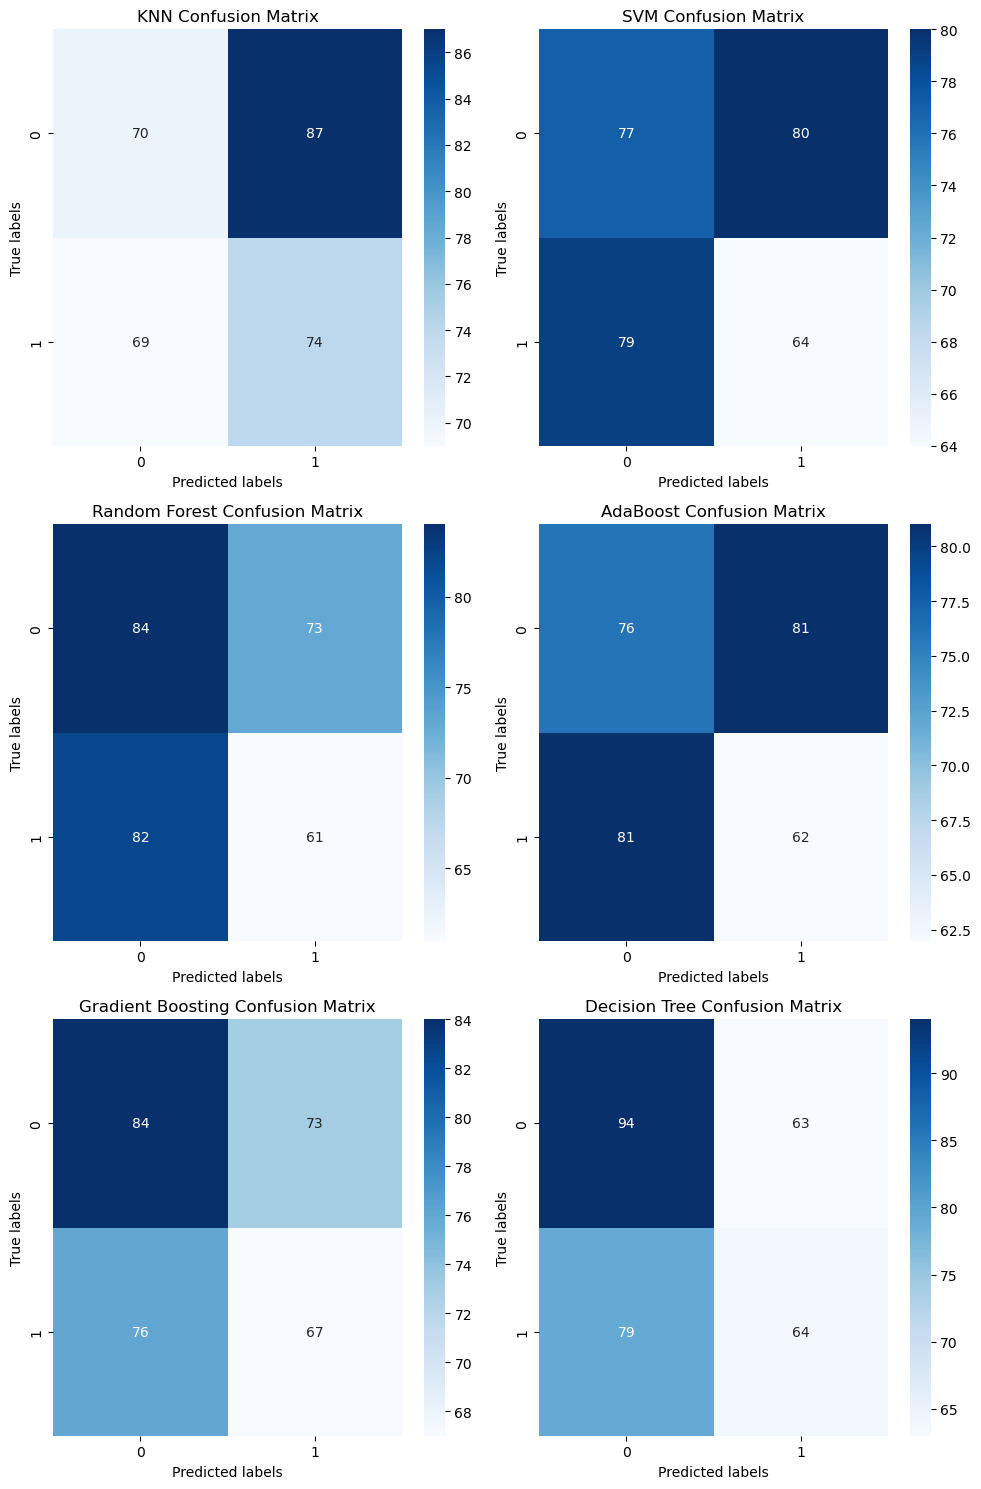

In [29]:
# Confusion matrix для каждого алгоритма
fig, axs = plt.subplots(3, 2, figsize=(10, 15))

# Преобразование в одномерный массив для удобной индексации
axs = axs.flatten()

for index, (name, model) in enumerate(models):
    model.fit(X_train_place, y_train_place)
    y_pred_place = model.predict(X_test_place)
    cm = confusion_matrix(y_test_place, y_pred_place)
    
    # Heatmap, подписи осей и заголовок
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[index])
    axs[index].set_title(f'{name} Confusion Matrix')
    axs[index].set_xlabel('Predicted labels')
    axs[index].set_ylabel('True labels')
    
    # Вывод classification_report
    #print(f"Classification Report for {name}:")
    #print(classification_report(y_test_place, y_pred_place))
    #print("\n" + "="*60 + "\n")

plt.tight_layout()
plt.show()

Точность моделей в районе 50% (стандартизация особо не влияет на метрику). Например, в KNN: из 157 не принятых абитуриентов только 70 распознаны как не принятые. Из 143 принятых абитуриентов только 74 распознаны как принятые.